# Predictive modeling of genres in Project Gutenberg

Train classifiers, adding features at each step:
- Topic weights
- Cosine Delta 100 MFW
- Biber features
- Readability features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import pipeline, linear_model, model_selection, metrics, multioutput, svm, preprocessing

In [2]:
genres = ['Western', 'Adventure', 'Love', 'War', 'Humour', 'Sea',
                'Pulp fiction', 'SciFi & Fantasy', 'General fiction',
                'Mystery & Detective stories', 'Juvenile', 'Translations']
md = pd.read_csv('metadata-pg-genres-subset.tsv', sep='\t', index_col='id')
md

,title,author,gender,year-birth,year-death,year-worldcat,year-ref,language,translation,downloads,...,Love,War,Humour,Sea,Pulp fiction,SciFi & Fantasy,General fiction,Mystery & Detective stories,Juvenile,Translations
id,,,,,,,,,,,,,,,,,,,,,
PG66248,"The Texas Hawks; or, The Strange Decoy","Badger, Jos. E. (Joseph Edward)",NaN,1848.0,1909.0,1871.0,1871,['en'],NaN,61,...,0,0,0,0,1,0,0,0,0,0
PG50246,Running to Waste: The Story of a Tomboy,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,10,...,0,0,0,0,0,0,0,0,1,0
PG49170,Summer Days,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,7,...,0,0,0,0,0,0,0,0,1,0
PG21740,The Iron Horse,"Ballantyne, R. M. (Robert Michael)",NaN,1825.0,1894.0,1871.0,1871,['en'],NaN,28,...,0,0,0,0,0,0,0,0,1,0
PG29623,The Cuckoo Clock,"Barefoot, Wesley",NaN,NaN,NaN,1871.0,1871,['en'],NaN,17,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG59516,The Scamperers,"Stearns, Charles A.",NaN,NaN,NaN,2018.0,2018,['en'],NaN,11,...,0,0,0,0,0,1,0,0,0,0
PG61133,The Happy Homicide,"Banta, Frank",NaN,NaN,NaN,2019.0,2019,['en'],NaN,5,...,0,0,0,0,0,1,0,0,0,0
PG64314,Beyond the X Ecliptic,"Holden, Fox B.",NaN,1923.0,NaN,2019.0,2019,['en'],NaN,12,...,0,0,0,0,0,1,0,0,0,0


In [3]:
topicweights = pd.read_csv('doctopics_pertext.tsv.gz', sep='\t', index_col=0)
topicweights

,t0: madame monsieur mademoiselle,t1: sir master lord,t2: eyes face looked,t3: uncle boy wiggily,t4: men enemy fire,t5: ses ave wot,t6: dog rabbit time,t7: car train street,t8: house farm farmer,t9: fact eye person,...,t90: hand head feet,t91: boat water sea,t92: wilfrid beauchamp woman,t93: table eat water,t94: boys boy camp,t95: garden trees green,t96: angus laird scotland,t97: herrick brand carr,t98: face eyes death,t99: squire sir day
ID,,,,,,,,,,,,,,,,,,,,,
PG10002,0.000030,0.001331,0.026010,0.000799,0.000218,0.000015,0.009403,0.002292,0.000036,0.000795,...,0.072651,0.003736,0.000008,0.002898,0.004300,0.013728,0.000011,0.000008,0.030394,0.000011
PG10008,0.000030,0.000077,0.055917,0.000105,0.002505,0.000176,0.002584,0.000802,0.000036,0.043174,...,0.072016,0.032317,0.000089,0.011744,0.005965,0.001282,0.000373,0.000008,0.018056,0.000292
PG10027,0.000031,0.000199,0.019394,0.000276,0.015277,0.011502,0.005511,0.011781,0.000196,0.025624,...,0.052107,0.000355,0.000008,0.040586,0.036174,0.009408,0.000012,0.000008,0.003189,0.000012
PG10046,0.001092,0.173777,0.015615,0.001183,0.019380,0.000110,0.001301,0.000338,0.003156,0.006930,...,0.064296,0.003929,0.000040,0.014373,0.000696,0.035798,0.072929,0.000039,0.056602,0.000167
PG10048,0.000308,0.000384,0.087311,0.001020,0.000613,0.000159,0.005503,0.028604,0.002750,0.004934,...,0.022897,0.000829,0.000084,0.035065,0.073785,0.001685,0.000116,0.000079,0.009263,0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG9981,0.006782,0.000538,0.011059,0.017504,0.002008,0.000015,0.002173,0.023491,0.002073,0.063518,...,0.007150,0.004360,0.000083,0.030631,0.000621,0.011916,0.000036,0.000008,0.012091,0.000011
PG9986,0.000030,0.000037,0.027600,0.000024,0.000921,0.002373,0.005515,0.010521,0.000650,0.004292,...,0.010496,0.006427,0.000008,0.021545,0.002271,0.001547,0.000011,0.000008,0.030608,0.001147
PG9988,0.000037,0.000496,0.026635,0.000030,0.001122,0.000019,0.000785,0.004863,0.018258,0.062430,...,0.000427,0.000948,0.000121,0.034136,0.001164,0.006654,0.000014,0.000009,0.000511,0.000014


In [4]:
with open('test.txt', encoding='utf8') as inp:
    test_ids = inp.read().splitlines()
train_index = ~topicweights.index.isin(test_ids)
test_index = topicweights.index.isin(test_ids)

In [5]:
# Load stop words and BoW
with open('sw_jockers.txt', encoding='utf8') as inp:
    stopwords = inp.read().splitlines()
MFW = 1000
bow = pd.read_csv('bow5000.csv.gz', index_col=0)
# Pick from 1000 MFW only the words that occur in the stop words list:
bow = bow.iloc[:, :MFW]
bow1000 = bow.columns
bow = bow.loc[:, bow.columns.isin(stopwords)]
bow_train = bow.loc[train_index, :]
# Turn word counts into z-scores based on training set
scaler = pipeline.Pipeline([
        ('norm', preprocessing.Normalizer(norm='l1')),
        ('scale', preprocessing.StandardScaler())])
scaler.fit(bow_train)
# Apply z-scoring to whole corpus
cosinedelta = pd.DataFrame(scaler.transform(bow), index=bow.index, columns=bow.columns)
cosinedelta.columns = ['w_' + a for a in cosinedelta.columns]
cosinedelta

,the,and,to,of,a,i,he,in,was,that,...,mark,hung,goes,spring,they're,everybody,third,grace,begin,entirely
id,,,,,,,,,,,,,,,,,,,,,
PG10002,0.917403,0.286217,-0.109315,1.205207,0.820806,3.430345,-1.819176,-0.478518,0.955388,2.117015,...,-0.105711,-0.225221,-0.497673,-0.506291,-0.562286,-0.616282,-0.283121,-0.171884,0.075683,0.107005
PG10008,1.079147,-0.829717,-0.343616,0.680194,0.865312,0.519929,-0.158939,-0.015769,0.094744,-0.382282,...,-0.118286,0.666074,0.340846,0.305684,0.234674,-0.233707,-0.163269,-0.103640,-0.089355,-0.349182
PG10027,0.854199,0.277683,0.450571,0.831580,0.493467,-0.441736,-1.035938,0.522115,-0.081873,-0.883956,...,0.090034,0.032531,0.466636,-0.452769,1.038588,0.299500,2.000578,-0.171884,-0.434196,-0.026592
PG10046,0.430288,0.914215,-1.096497,0.668909,1.774351,2.141653,-0.613703,0.896525,0.557039,0.015485,...,0.088197,0.865208,-0.420352,-0.279863,-0.187570,-0.486368,0.433729,0.106202,-0.418999,-0.784587
PG10048,-0.809015,-0.390755,0.122427,-1.312098,-0.225460,-0.121607,-1.522534,-0.329830,-1.262043,0.172156,...,-0.173289,-0.661873,-0.339168,-0.634663,-0.208351,0.488093,-0.224374,-0.122634,-0.811185,-0.784587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG9981,-0.561132,-0.100297,0.349793,0.523905,-0.105510,-0.100556,-0.206619,0.014878,-1.033079,0.557625,...,-0.072836,-0.580875,0.432431,1.382590,1.101163,0.032521,-0.095784,-0.029443,0.318791,0.351408
PG9986,-1.612441,-0.706711,1.003558,-1.056984,-1.055114,1.477139,-1.856274,-0.832419,-1.366572,-0.514702,...,-0.062234,-0.589448,-0.229087,-0.564342,-0.355987,-0.423168,-0.312376,-0.171884,0.937747,0.387578
PG9988,-0.048940,0.315006,1.549206,-0.307438,0.190737,0.249749,-0.612127,0.329649,-0.350533,-0.826852,...,-0.026076,0.503284,0.664191,-0.215194,0.011994,-0.488288,-0.253133,0.102093,0.541186,1.157662


In [6]:
# all 1000 most frequent words:
print(list(bow1000))

['the', 'and', 'to', 'of', 'a', 'i', 'he', 'in', 'was', 'that', 'it', 'you', 'his', 'her', 'had', 'she', 'with', 'for', 'as', 'but', 'at', 'not', 'on', 'him', 'be', 'is', 'have', 'said', 'they', 'me', 'all', 'my', 'this', 'from', 'so', 'were', 'by', 'there', 'one', 'no', 'if', 'would', 'what', 'we', 'which', 'an', 'out', 'up', 'when', 'been', 'then', 'them', 'do', 'or', 'could', 'who', 'are', 'will', 'now', 'their', 'your', 'into', 'about', 'little', 'man', 'like', 'more', 'did', 'know', 'very', 'time', 'some', 'see', 'down', 'well', 'over', 'only', 'come', 'back', 'before', 'go', 'can', 'mr', 'than', 'any', 'good', 'how', 'after', 'here', 'upon', 'came', 'old', 'two', 'way', 'never', 'think', 's', 'made', 'other', 'just', 'has', "don't", 'must', 'eyes', 'again', 'much', 'too', 'us', 'say', 'where', 'should', 'went', 'get', 'day', 'away', 'thought', 'long', 'our', 'face', 'himself', 'first', 'am', 'might', 'through', 'its', 'hand', 'such', 'great', 'looked', 'even', 'make', 'own', 'mrs

In [7]:
# The ones selected after intersecting with the stop word list:
print(list(bow.columns))

['the', 'and', 'to', 'of', 'a', 'i', 'he', 'in', 'was', 'that', 'it', 'you', 'his', 'her', 'had', 'she', 'with', 'for', 'as', 'but', 'at', 'not', 'on', 'him', 'be', 'is', 'have', 'said', 'they', 'me', 'all', 'my', 'this', 'from', 'so', 'were', 'by', 'there', 'one', 'no', 'if', 'would', 'what', 'we', 'which', 'an', 'out', 'up', 'when', 'been', 'then', 'them', 'do', 'or', 'could', 'who', 'are', 'will', 'now', 'their', 'your', 'into', 'about', 'little', 'man', 'like', 'more', 'did', 'know', 'very', 'some', 'see', 'down', 'well', 'over', 'only', 'come', 'back', 'before', 'go', 'can', 'mr', 'than', 'any', 'good', 'how', 'after', 'here', 'upon', 'came', 'old', 'two', 'way', 'never', 'think', 's', 'made', 'other', 'just', 'has', "don't", 'must', 'again', 'much', 'too', 'us', 'say', 'where', 'should', 'went', 'get', 'away', 'thought', 'long', 'our', 'himself', 'first', 'am', 'might', 'through', 'its', 'such', 'great', 'even', 'make', 'own', 'mrs', 'take', 'tell', 'why', 'right', 'off', 'going'

In [8]:
# load biber features
biberfeatures = pd.read_csv('gutenberg-biber.dat.gz', sep='\t')
biberfeatures[['filename', 'genre']] = biberfeatures['ID-Top'].str.split('-', expand=True)
biberfeatures = biberfeatures.set_index('filename').loc[topicweights.index, :].drop(columns=['genre', 'ID-Top'])
print((biberfeatures.index == topicweights.index).all())
biberfeatures.columns = ['b_' + a for a in biberfeatures.columns]
biberfeatures

True


,A01.pastVerbs,A03.presVerbs,B04.placeAdverbials,B05.timeAdverbials,C06.1persProns,C07.2persProns,C08.3persProns,C09.impersProns,C10.demonstrProns,C11.indefProns,...,K57.suasiveVerbs,K58.seemappear,L52.possibModals,L53.necessModals,L54.predicModals,N59.contractions,N60.thatDeletion,N61.strandedPrep,P66.syntNegn,P67.analNegn
ID,,,,,,,,,,,,,,,,,,,,,
PG10002,0.06000,0.01605,0.00471,0.00579,0.02375,0.01530,0.04592,0.01188,0.01213,0.00346,...,0.00181,0.00124,0.00405,0.00181,0.00625,0.02012,0.01859,0.00186,0.00022,0.01223
PG10008,0.04886,0.01926,0.00226,0.00414,0.02927,0.01515,0.04092,0.01063,0.01080,0.00280,...,0.00125,0.00081,0.00505,0.00207,0.00585,0.03970,0.01937,0.00127,0.00070,0.01346
PG10027,0.06577,0.01292,0.00634,0.00443,0.01644,0.01039,0.05589,0.00997,0.00693,0.00211,...,0.00134,0.00092,0.00435,0.00210,0.00574,0.00992,0.01454,0.00171,0.00022,0.01038
PG10046,0.06599,0.01001,0.00592,0.00513,0.01346,0.00447,0.05323,0.01342,0.01763,0.00202,...,0.00109,0.00158,0.00415,0.00108,0.00270,0.00860,0.01653,0.00069,0.00044,0.00593
PG10048,0.04935,0.01791,0.00254,0.00490,0.03143,0.02035,0.05835,0.01067,0.00719,0.00205,...,0.00304,0.00103,0.00533,0.00314,0.00908,0.01579,0.02087,0.00137,0.00040,0.01321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG9981,0.03712,0.02099,0.00397,0.00417,0.03345,0.02145,0.03667,0.01313,0.01127,0.00282,...,0.00069,0.00027,0.00497,0.00162,0.00582,0.03774,0.01177,0.00268,0.00010,0.01599
PG9986,0.06570,0.01564,0.00336,0.00574,0.05449,0.01177,0.03653,0.01040,0.01079,0.00253,...,0.00190,0.00140,0.00586,0.00220,0.00473,0.00000,0.01956,0.00092,0.00024,0.00936
PG9988,0.05495,0.01534,0.00262,0.00407,0.05010,0.00223,0.03141,0.00944,0.01764,0.00138,...,0.00092,0.00131,0.00433,0.00282,0.00387,0.00184,0.01154,0.00013,0.00105,0.00977


In [9]:
readability = pd.read_csv('gutenberg_readability.csv', index_col=0)
readability

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,characters_per_word,...,complex_words_dc,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,interrogative,article,subordination
PG10002,5.794542,7.301198,7.455603,84.677652,10.351692,33.975528,9.633764,2.883276,3.980552,4.242908,...,10105,1616,495,160,900,356,418,57,291,122
PG10008,3.853829,4.802547,6.999764,88.770314,8.203424,29.265543,8.536389,2.070811,3.762777,4.297776,...,13614,1868,790,149,1325,379,637,108,555,120
PG10027,7.101628,9.029971,7.751944,81.409588,11.580449,37.237062,10.099319,3.413494,3.708885,4.246196,...,12642,2465,771,42,580,206,844,64,420,79
PG10046,4.593037,5.987694,5.988446,92.707045,8.808757,29.972582,8.000735,2.198384,3.474111,3.998887,...,15522,3142,1369,309,1898,531,504,109,488,141
PG10048,4.537061,5.793477,6.525645,90.406974,8.729350,28.560327,8.383896,2.020489,3.133311,4.118660,...,6499,1205,551,117,268,117,227,39,102,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG9981,5.693171,7.137942,7.204999,85.562300,10.016840,32.716539,9.272680,2.660934,3.632620,4.198838,...,21450,3812,1651,430,1937,532,854,163,507,148
PG9986,3.461521,4.160927,5.370366,94.893297,7.678278,25.482206,7.715965,1.611311,2.573717,3.964249,...,10558,3148,1950,119,1591,219,413,214,191,135
PG9988,4.748068,5.785922,7.003869,87.140411,9.311206,31.700533,9.155795,2.498250,3.816572,4.221583,...,9835,1445,683,101,794,170,502,68,216,53
PG9990,4.003238,4.654680,6.152039,90.377223,8.585004,28.328809,8.681128,2.001669,3.000829,4.106762,...,8350,2000,1205,107,911,252,575,78,194,77


In [25]:
readability.describe().T

,count,mean,std,min,25%,50%,75%,max
Kincaid,9799.0,5.264741,2.187792,-4.026922,3.795363,4.974456,6.359823,3.484683e+01
ARI,9799.0,6.624518,2.636551,-0.798093,4.860276,6.226174,7.870816,4.453930e+01
Coleman-Liau,9799.0,6.982587,1.219619,1.155522,6.217659,6.968970,7.744455,1.459442e+01
FleschReadingEase,9799.0,86.735801,8.433955,14.511185,81.943594,87.194727,92.213045,1.685304e+02
GunningFogIndex,9799.0,9.574791,2.187190,3.238537,8.107591,9.248920,10.685888,3.926692e+01
LIX,9799.0,31.991407,5.768362,13.257266,28.142973,31.252752,34.811210,1.076098e+02
SMOGIndex,9799.0,8.956518,1.263820,3.000000,8.122878,8.847089,9.662156,1.716726e+01
RIX,9799.0,2.562921,0.960086,0.381384,1.930879,2.393172,2.971660,2.100000e+01
DaleChallIndex,9799.0,3.695006,0.628291,1.492342,3.266618,3.653040,4.093171,1.064925e+01
characters_per_word,9799.0,4.202962,0.186374,3.262604,4.088835,4.204303,4.320890,5.611659e+00


In [43]:
# Turn word counts into z-scores based on training set
scaler = preprocessing.StandardScaler()
scaler.fit(readability.loc[train_index, :])
# Apply z-scoring to whole corpus
readability = pd.DataFrame(scaler.transform(readability), index=readability.index, columns=readability.columns)
readability.columns = ['r_' + a for a in readability.columns]

In [44]:
readability.describe().T

,count,mean,std,min,25%,50%,75%,max
Kincaid,9799.0,0.002050,1.005757,-4.269449,-0.673442,-0.131398,0.505474,13.601321
ARI,9799.0,0.001821,1.007932,-2.835782,-0.672634,-0.150462,0.478270,14.496327
Coleman-Liau,9799.0,0.001810,0.999172,-4.772010,-0.624857,-0.009345,0.625970,6.237801
FleschReadingEase,9799.0,-0.002480,1.002631,-8.588560,-0.572178,0.052078,0.648657,9.721281
GunningFogIndex,9799.0,0.002170,1.005286,-2.910126,-0.672191,-0.147609,0.512857,13.649393
LIX,9799.0,0.002279,1.008581,-3.273330,-0.670609,-0.126873,0.495313,13.223923
SMOGIndex,9799.0,0.001988,1.003314,-4.726738,-0.659817,-0.084885,0.562176,6.520286
RIX,9799.0,0.003672,1.020779,-2.315773,-0.668325,-0.176808,0.438249,19.606264
DaleChallIndex,9799.0,0.001935,1.012886,-3.549045,-0.688682,-0.065719,0.643829,11.213075
characters_per_word,9799.0,0.001868,0.997997,-5.033565,-0.609260,0.009049,0.633347,7.545167


In [10]:
X = pd.concat([topicweights, cosinedelta, biberfeatures, readability], axis=1)
y = md.loc[topicweights.index, genres]

In [11]:
X_train, y_train = X.loc[train_index, :], y.loc[train_index, :]
X_test, y_test = X.loc[test_index, :], y.loc[test_index, :]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(len(set(y_train.index) & set(y_test.index)) == 0)

(8819, 596) (8819, 12)
(980, 596) (980, 12)
True


## Train models

In [53]:
def clfreport(df):
    """Post-process scikit-learn classifiction_report, returns DataFrame with rounded percentages."""
    df = df.copy()
    df.iloc[:, 0:3] *= 100
    df[df.columns[3]] = df[df.columns[3]].astype(int)
    return df.round(1)


def evalmodel(X_train, X_test, y_train, y_test, target_names, features):
    """Train and evaluate model with given features."""
    model = multioutput.MultiOutputClassifier(linear_model.LogisticRegressionCV(cv=3, max_iter=1000, solver='liblinear', penalty='l1', random_state=0, class_weight=None, n_jobs=-1))
    model.fit(X_train.loc[:, features], y_train)
    y_pred = model.predict(X_test.loc[:, features])
    scores = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=target_names, zero_division=0, output_dict=True)).T
    return model, scores

In [54]:
features1 = list(topicweights.columns)
model1, scores1 = evalmodel(X_train, X_test, y_train, y_test, genres, features1)
clfreport(scores1)

,precision,recall,f1-score,support
Western,82.4,43.8,57.1,32
Adventure,0.0,0.0,0.0,114
Love,100.0,1.6,3.2,62
War,0.0,0.0,0.0,19
Humour,0.0,0.0,0.0,24
Sea,73.3,52.4,61.1,21
Pulp fiction,100.0,62.5,76.9,16
SciFi & Fantasy,96.1,89.5,92.7,247
General fiction,74.8,71.6,73.1,348
Mystery & Detective stories,83.0,57.5,67.9,127


In [55]:
features2 = list(topicweights.columns) + list(cosinedelta.columns)
model2, scores2 = evalmodel(X_train, X_test, y_train, y_test, genres, features2)
clfreport(scores2)

/home/andreas/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,precision,recall,f1-score,support
Western,65.2,46.9,54.5,32
Adventure,0.0,0.0,0.0,114
Love,0.0,0.0,0.0,62
War,0.0,0.0,0.0,19
Humour,0.0,0.0,0.0,24
Sea,0.0,0.0,0.0,21
Pulp fiction,100.0,75.0,85.7,16
SciFi & Fantasy,93.4,91.1,92.2,247
General fiction,73.4,74.4,73.9,348
Mystery & Detective stories,78.6,60.6,68.4,127


In [56]:
features3 = list(topicweights.columns) + list(cosinedelta.columns) + list(biberfeatures.columns)
model3, scores3 = evalmodel(X_train, X_test, y_train, y_test, genres, features3)
clfreport(scores3)

,precision,recall,f1-score,support
Western,60.9,43.8,50.9,32
Adventure,0.0,0.0,0.0,114
Love,0.0,0.0,0.0,62
War,0.0,0.0,0.0,19
Humour,0.0,0.0,0.0,24
Sea,0.0,0.0,0.0,21
Pulp fiction,100.0,75.0,85.7,16
SciFi & Fantasy,94.0,88.7,91.3,247
General fiction,73.0,74.4,73.7,348
Mystery & Detective stories,80.0,63.0,70.5,127


In [57]:
features4 = list(topicweights.columns) + list(cosinedelta.columns) + list(biberfeatures.columns) + list(readability.columns)
model4, scores4 = evalmodel(X_train, X_test, y_train, y_test, genres, features4)
clfreport(scores4)

,precision,recall,f1-score,support
Western,58.3,43.8,50.0,32
Adventure,0.0,0.0,0.0,114
Love,0.0,0.0,0.0,62
War,0.0,0.0,0.0,19
Humour,0.0,0.0,0.0,24
Sea,60.0,42.9,50.0,21
Pulp fiction,100.0,75.0,85.7,16
SciFi & Fantasy,94.5,89.9,92.1,247
General fiction,74.3,73.9,74.1,348
Mystery & Detective stories,77.8,60.6,68.1,127


In [58]:
featuretypes = ['Topic weights', 'Cosine Delta', 'Biber features', 'Readability']
overall = pd.DataFrame({name: scores['f1-score'] for name, scores in zip(featuretypes, [scores1, scores2, scores3, scores4])})
overall *= 100
overall['support'] = scores1['support'].astype(int)
overall.round(1)

,Topic weights,Cosine Delta,Biber features,Readability,support
Western,57.1,54.5,50.9,50.0,32
Adventure,0.0,0.0,0.0,0.0,114
Love,3.2,0.0,0.0,0.0,62
War,0.0,0.0,0.0,0.0,19
Humour,0.0,0.0,0.0,0.0,24
Sea,61.1,0.0,0.0,50.0,21
Pulp fiction,76.9,85.7,85.7,85.7,16
SciFi & Fantasy,92.7,92.2,91.3,92.1,247
General fiction,73.1,73.9,73.7,74.1,348
Mystery & Detective stories,67.9,68.4,70.5,68.1,127


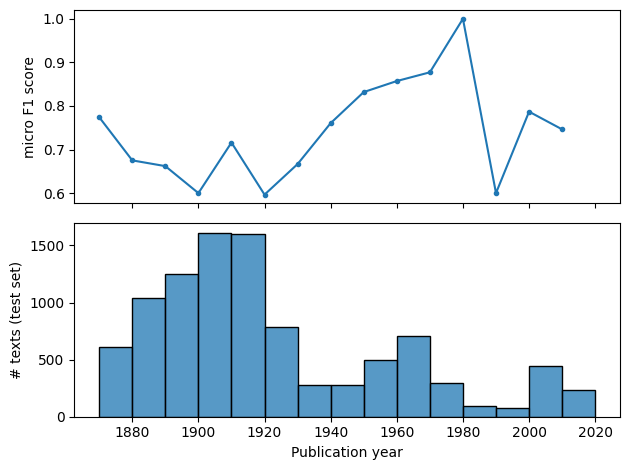

In [161]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
clfpreds = pd.DataFrame(model1.predict(X_test[topicweights.columns]), index=y_test.index, columns=genres)
years = md.loc[topicweights.index, 'year-ref']
decades = range(years.min() // 10 * 10, years.max() // 10 * 10 + 1, 10)
y_test.groupby(years // 10 * 10).apply(
        lambda decade: metrics.f1_score(decade, clfpreds.loc[decade.index, :], average='micro')).plot(ax=ax1, marker='.');
sns.histplot(years, bins=decades, ax=ax2);
ax1.set_ylabel('micro F1 score'); ax2.set_ylabel('# texts (test set)'); ax2.set_xlabel('Publication year');
fig.tight_layout(); fig.savefig('fig/fig5.13f1bydecade.pdf'); fig.savefig('fig/5.13f1bydecade.png', dpi=150)

## Analysis of feature weights

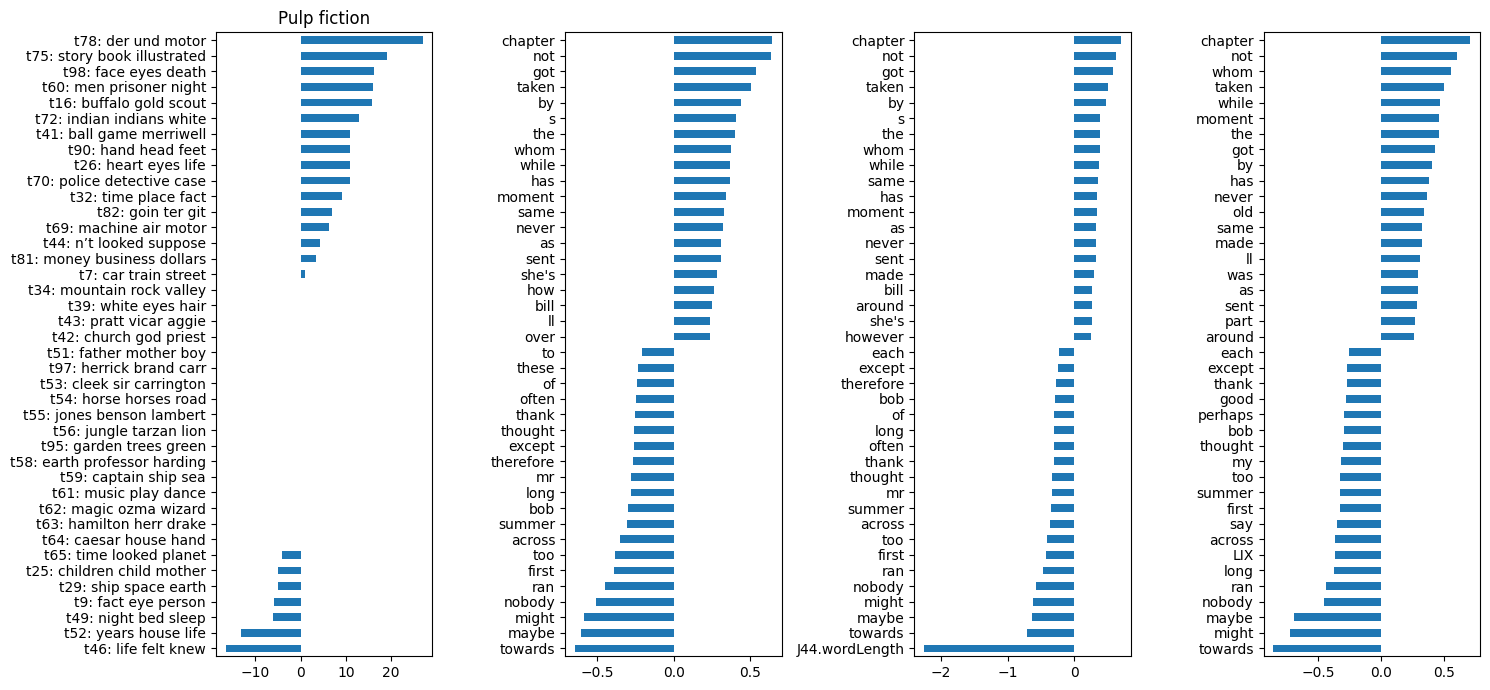

In [146]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
n = 6
fv = pd.Series(model1.estimators_[n].coef_[0], index=X_train.loc[:, features1].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[0]);
fv = pd.Series(model2.estimators_[n].coef_[0], index=X_train.loc[:, features2].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[1]);
fv = pd.Series(model3.estimators_[n].coef_[0], index=X_train.loc[:, features3].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[2]);
fv = pd.Series(model4.estimators_[n].coef_[0], index=X_train.loc[:, features4].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[3]);
ax[0].set_title(genres[n])
fig.tight_layout()

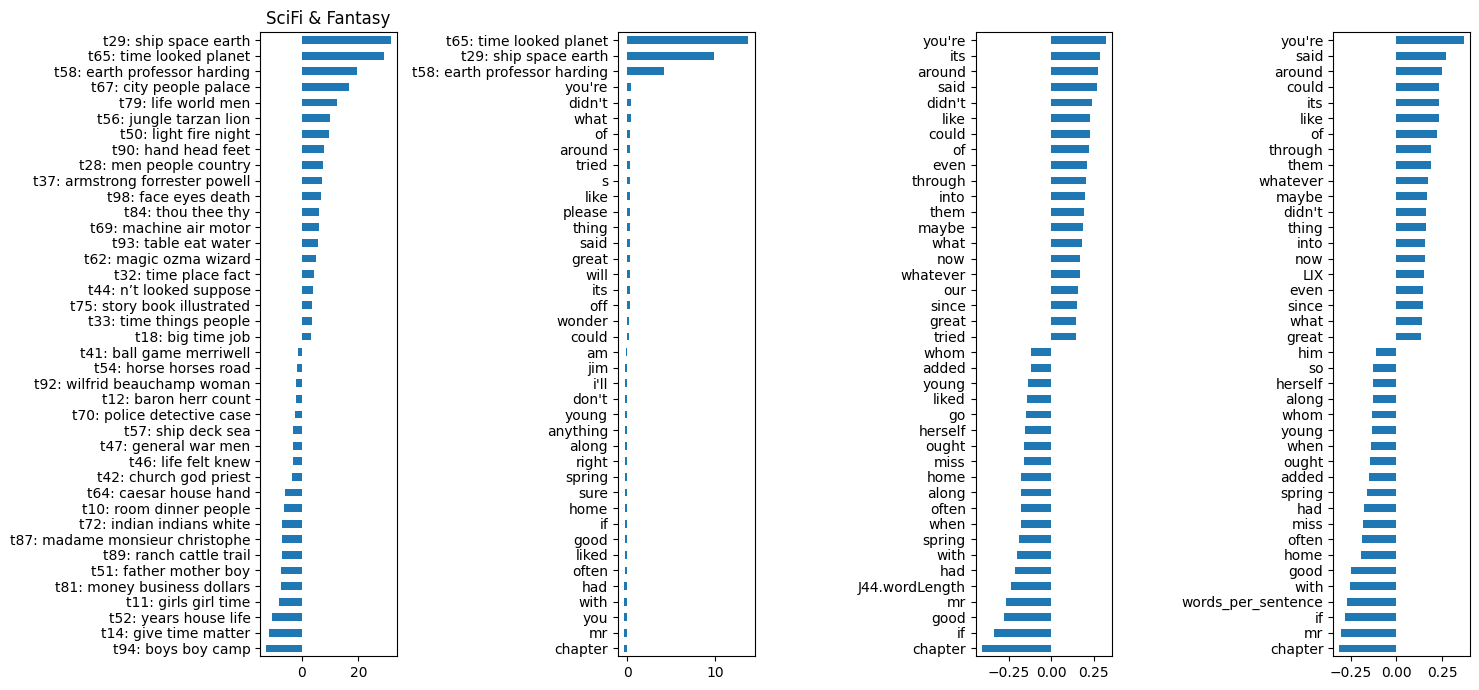

In [144]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
n = 7
fv = pd.Series(model1.estimators_[n].coef_[0], index=X_train.loc[:, features1].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[0]);
fv = pd.Series(model2.estimators_[n].coef_[0], index=X_train.loc[:, features2].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[1]);
fv = pd.Series(model3.estimators_[n].coef_[0], index=X_train.loc[:, features3].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[2]);
fv = pd.Series(model4.estimators_[n].coef_[0], index=X_train.loc[:, features4].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[3]);
ax[0].set_title(genres[n])
fig.tight_layout()

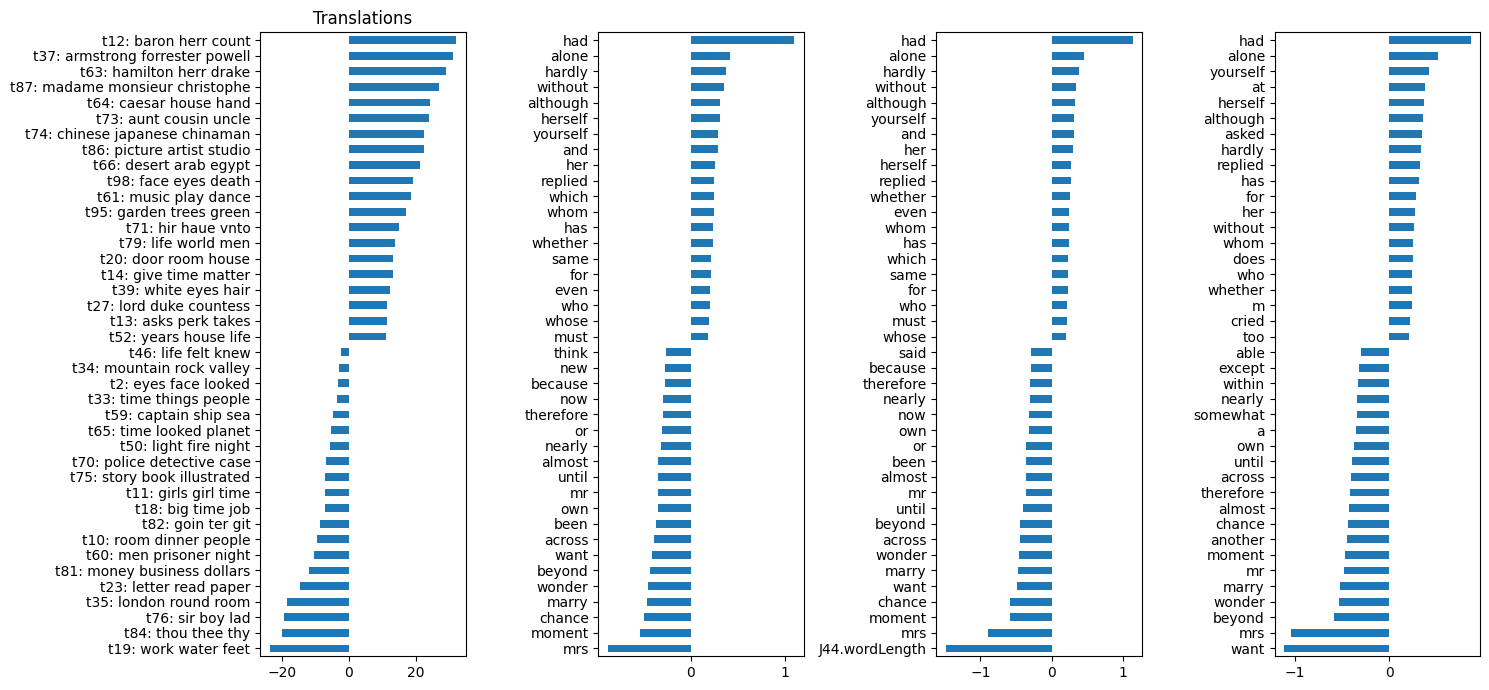

In [143]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
n = 11
fv = pd.Series(model1.estimators_[n].coef_[0], index=X_train.loc[:, features1].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[0]);
fv = pd.Series(model2.estimators_[n].coef_[0], index=X_train.loc[:, features2].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[1]);
fv = pd.Series(model3.estimators_[n].coef_[0], index=X_train.loc[:, features3].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[2]);
fv = pd.Series(model4.estimators_[n].coef_[0], index=X_train.loc[:, features4].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[3]);
ax[0].set_title(genres[n])
fig.tight_layout()

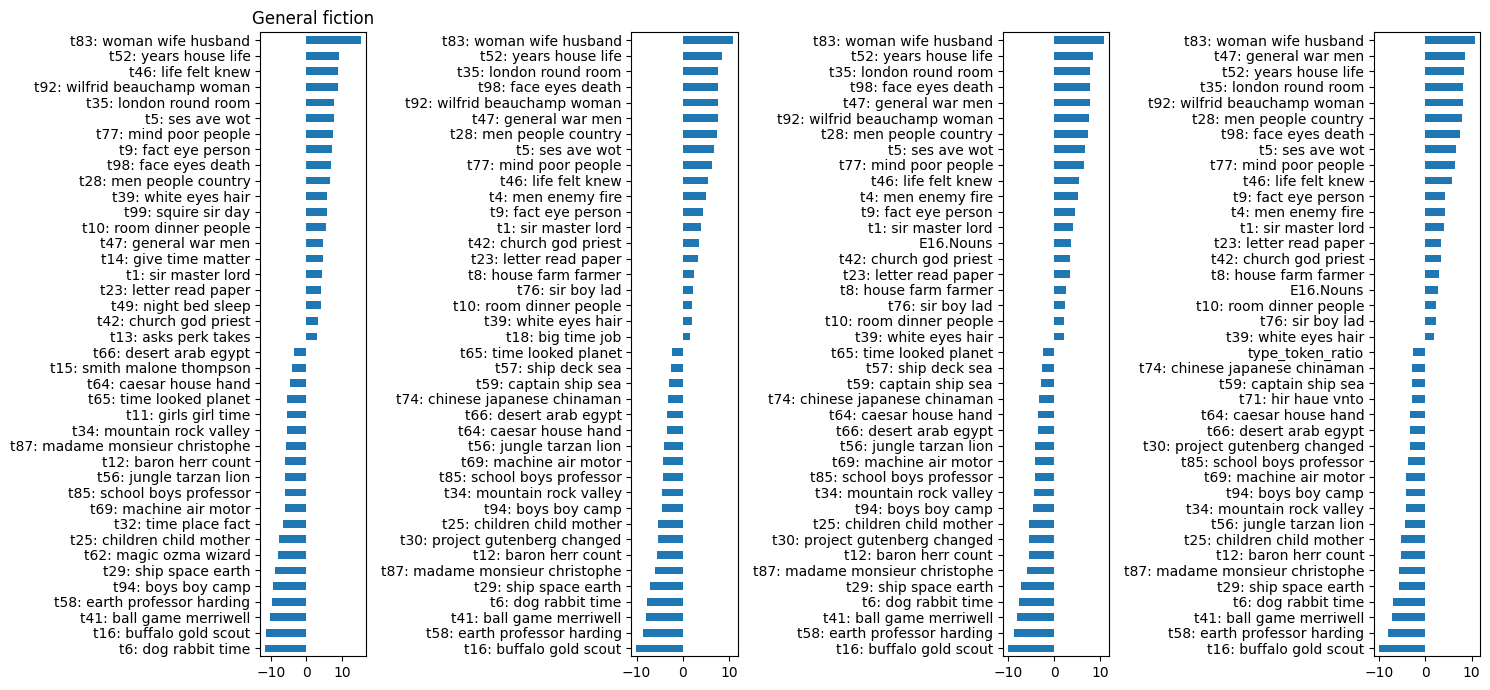

In [142]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
n = 8
fv = pd.Series(model1.estimators_[n].coef_[0], index=X_train.loc[:, features1].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[0]);
fv = pd.Series(model2.estimators_[n].coef_[0], index=X_train.loc[:, features2].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[1]);
fv = pd.Series(model3.estimators_[n].coef_[0], index=X_train.loc[:, features3].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[2]);
fv = pd.Series(model4.estimators_[n].coef_[0], index=X_train.loc[:, features4].columns).sort_values()
pd.concat([fv.head(20), fv.tail(20)]).plot.barh(ax=ax[3]);
ax[0].set_title(genres[n])
fig.tight_layout()

## Analysis of (Mis)classifications

In [91]:
y_pred = model1.predict(X_test[topicweights.columns])
y_prob = model1.predict_proba(X_test[topicweights.columns])
y_probdf = pd.DataFrame([a[:, 1] for a in y_prob], columns=y_test.index, index=genres).T
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

In [92]:
pd.options.display.width = 200
print('Genres in metadata that were not predicted')
for genre in genres:
    print(genre)
    subset = md.loc[y_test.index, :].loc[(y_test[genre] == 1) & (y_pred[genre] == 0), :].copy()
    subset.insert(0, 'prob', y_probdf.loc[subset.index, genre])
    subset = subset.sort_values('prob')
    subset = subset.loc[:, ['prob', 'year-ref', 'author', 'title']]
    print(subset.head())
    print()

Genres in metadata that were not predicted
Western
             prob  year-ref               author                                              title
ID                                                                                                 
PG24033  0.014979      1906  Stratemeyer, Edward  Dave Porter in the Gold Fields; Or, The Search...
PG7496   0.032361      1908      Young, Clarence  Jack Ranger's Western Trip; Or, from Boarding ...
PG19810  0.045028      1920        Cather, Willa                                         My Ántonia
PG19472  0.057535      1892       Lynde, Francis                                            Branded
PG22571  0.073182      1896    Standish, Burt L.                          Frank Merriwell's Bravery

Adventure
         prob  year-ref                             author                                              title
ID                                                                                                           
PG10109   0.5     

In [93]:
pd.options.display.width = 200
print('Predicted genres that are not in metadata')
for genre in genres:
    print(genre)
    subset = md.loc[y_test.index, :].loc[(y_test[genre] == 0) & (y_pred[genre] == 1), :].copy()
    subset.insert(0, 'prob', y_probdf.loc[subset.index, genre])
    subset = subset.sort_values('prob')
    subset = subset.loc[subset['prob'] > 0.9, ['prob', 'year-ref', 'author', 'title', 'subjects']]
    print(subset.iloc[::-1, :])
    print()

Predicted genres that are not in metadata
Western
             prob  year-ref       author                         title                                           subjects
ID                                                                                                                       
PG45452  0.975673      1995  Clark, Joan  Connie Carl at Rainbow Ranch  {'Cliff-dwellings -- New Mexico -- Juvenile fi...

Adventure
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

Love
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

War
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

Humour
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

Sea
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

Pulp fiction
Empty DataFrame
Columns: [prob, year-ref, author, title, subjects]
Index: []

SciFi & Fantasy
             prob  year-ref                           au

## number of texts per genre

In [148]:
md[genres].sum()

Western                         366
Adventure                       968
Love                            574
War                             210
Humour                          216
Sea                             187
Pulp fiction                    147
SciFi & Fantasy                2578
General fiction                3470
Mystery & Detective stories     943
Juvenile                       1959
Translations                    269
dtype: int64

In [150]:
md.loc[topicweights.index, :].loc[test_index, genres].sum()

Western                         32
Adventure                      114
Love                            62
War                             19
Humour                          24
Sea                             21
Pulp fiction                    16
SciFi & Fantasy                247
General fiction                348
Mystery & Detective stories    127
Juvenile                       185
Translations                    24
dtype: int64

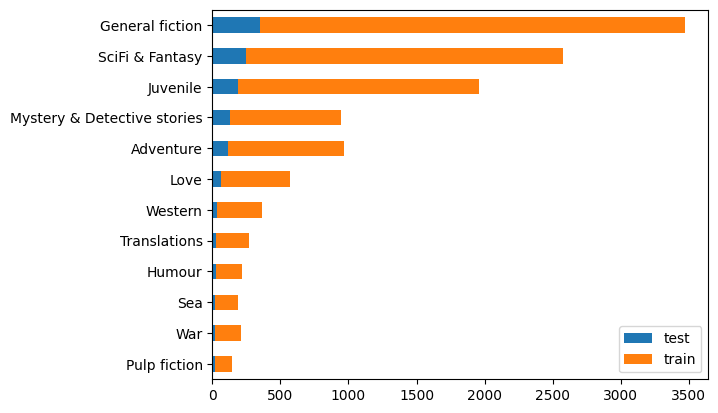

In [160]:
# Number of texts in train vs test for each genre
pd.concat({
    'test': md.loc[topicweights.index, :].loc[test_index, genres].sum(),
    'train': md.loc[topicweights.index, :].loc[train_index, genres].sum()},
    axis=1).sort_values('test').plot.barh(stacked=True);